In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
#import lightgbm as lgb
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder
import gc
import os
from tqdm import tqdm
from scipy.sparse import csr_matrix
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [ ]:
# Read the data
INPUT_DIR='m5-forecasting-accuracy/'
calendar=pd.read_csv(INPUT_DIR+'calendar.csv')
sales_train_val=pd.read_csv(INPUT_DIR+'sales_train_validation.csv')
ss_data=pd.read_csv(INPUT_DIR+'sample_submission.csv')

In [ ]:
timesteps=14
startDay=0

In [ ]:
sales_train_val.shape

In [ ]:
sales_train_val.head()

In [ ]:
calendar.head()

In [ ]:
ss_data.tail()

In [ ]:
sales_train_val.describe()

In [ ]:
sales_train_val.isnull()

In [ ]:
print(sales_train_val.info())

In [ ]:
# To reduce memory usage
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype in ['int32', 'int64']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: 
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
sales_train_val_downcast = downcast_dtypes(sales_train_val)

In [ ]:
print(sales_train_val_downcast.info())

In [ ]:
# Making dates as row to get the data in exact format
sales_train_val_downcast = sales_train_val_downcast.T

In [ ]:
sales_train_val_downcast.shape

In [ ]:
#remove first 6 rows as we do not need that to feed to our model
sales_train_val_downcast= sales_train_val_downcast[6+startDay:]
sales_train_val_downcast.head(8)

In [ ]:
# create a dataframe with zeores for 1969 days in the calendar - To store the knowledge if an event exist in the next day
daysBeforeEvent = pd.DataFrame(np.zeros((1969,1)))

In [ ]:
# "1" is assigned to the days before the event_name_1. 
for x, y in calendar.iterrows():
    if x!=0 and (pd.isnull(calendar['event_name_1'][x]) == False):
        daysBeforeEvent[0][x-1]=1

In [ ]:
# daysBeforeEvent is used as a feature and also to train and test the validations 
daysBeforeEventTest = daysBeforeEvent[1913:1941]
daysBeforeEventTrain = daysBeforeEvent[startDay:1913]
print(daysBeforeEventTest.shape)
print(daysBeforeEventTest)

In [ ]:
daysBeforeEventTrain.columns = ['oneDayBeforeEvent']
daysBeforeEventTrain.index = sales_train_val_downcast.index

In [ ]:
final_data = pd.concat([sales_train_val_downcast, daysBeforeEventTrain], axis=1)
print(final_data)

In [ ]:
# Feature scaling
# Scale the features using MinMaxScaler in range 0-1
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
final_data_scaled = sc.fit_transform(final_data)

print(final_data_scaled)

In [ ]:
final_data_scaled.shape

In [ ]:
#index=list(range(0,30491))

In [ ]:

import random
def data_split(full_list, ratio, shuffle=False):

    n_total = len(full_list)
    offset = int(n_total * ratio)
    if n_total == 0 or offset < 1:
        return [], full_list
    if shuffle:
        random.shuffle(full_list)
    sublist_1 = full_list[:offset]
    sublist_2 = full_list[offset:]
    return sublist_1, sublist_2

In [ ]:
#trainindex,testindex=data_split(index, ratio=0.8, shuffle=True)

In [ ]:
#final_data_scaled_train=final_data_scaled[:,trainindex]
#final_data_scaled_test=final_data_scaled[:,testindex]

In [ ]:
#final_data_scaled_train.shape

In [ ]:
#final_data_scaled_test.shape

In [ ]:
# creating sequences for LSTM model training
X_train = []
y_train = []

for i in range(timesteps,1913-startDay):
    X_train.append(final_data_scaled[i-timesteps:i])
    y_train.append(final_data_scaled[i][0:30490])

In [ ]:
#del final_data_scaled
#del calendar

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)


print(X_train.shape)
print(y_train.shape)

# LSTM model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Initializing the RNN
regressor = Sequential()

# Adding first LSTM layer and some dropout regularization
layer_1_units = 300
regressor.add(LSTM(units=layer_1_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding second LSTM layer and some dropout regularization
layer_2_units = 300
regressor.add(LSTM(units=layer_2_units, return_sequences=True))
regressor.add(Dropout(0.2))

# Adding third LSTM layer and some dropout regularization``
layer_3_units = 300
regressor.add(LSTM(units=layer_3_units))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units=30490))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

#Fitting the RNN to the trainign set
epoch_no = 45
batch_size_RNN = 50
History=regressor.fit(X_train, y_train, epochs=epoch_no, batch_size=batch_size_RNN,validation_split=0.2)



Epoch 1/45
31/31 [==============================] - 150s 4s/step - loss: 0.0149 - val_loss: 0.0196
Epoch 2/45
31/31 [==============================] - 208s 7s/step - loss: 0.0127 - val_loss: 0.0190
Epoch 3/45
27/31 [=========================>....] - ETA: 27s - loss: 0.0123

Text(0.5, 1.0, 'model train vs validation loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

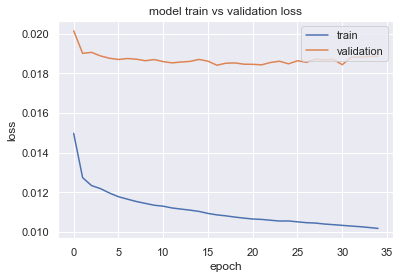

In [36]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

Text(0.5, 1.0, 'model train vs loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

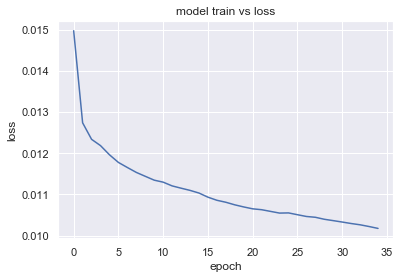

In [37]:
plt.plot(History.history['loss'])
#plt.plot(History.history['val_loss'])
plt.title('epoch vs loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train','validation'], loc='upper right')
plt.show()

In [ ]:
inputs = final_data[-timesteps:]
inputs = sc.transform(inputs)
print(inputs)

In [ ]:
X_test2 = []
X_test2.append(inputs[0:timesteps])
X_test2 = np.array(X_test2)
print(X_test.shape)
#print(X_test[0, 1:14].shape)
predictions = []

for j in range(timesteps, timesteps+28):
    predicted_sales = regressor.predict(X_test2[0, j-timesteps:j].reshape2(1, timesteps,30491))
    testInput = np.column_stack((np.array(predicted_sales), daysBeforeEventTest[0][1913+j-timesteps]))
    X_test2 = np.append(X_test, testInput).reshape(1, j+1, 30491)
    predicted_sales = sc.inverse_transform(testInput)[:,0:30490]
    predictions.append(predicted_sales)
print(testInput.shape)

In [ ]:
predicted_sales

# File submission

In [ ]:
import time
import matplotlib.pyplot as plt

submission = pd.DataFrame(data=np.array(predictions).reshape(28,30490))
submission = submission.T
submission = pd.concat((submission, submission), ignore_index=True)


idColumn =ss_data[['id']]
submission[['id']] = idColumn

cols = list(submission.columns)
cols = cols[-1:]+cols[:-1]
submission = submission[cols]

colsdname = ['id'] + [f'F{i}' for i in range(1,29)]
submission.columns = colsdname

currrentDatTime = time.strftime('%d%m%Y_%H%M%S')
submission.to_csv('submission.csv', index=False)
